[[-13, 30], [-4, 43], [-26.0, 39.0], [-17.0, 52.0]]


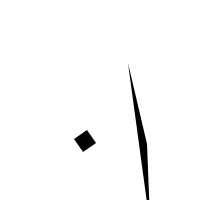

In [1]:
"""
# Test shape creation

"""
import sys
import drawsvg as dw

sys.path.append('./packages')
from synth.synthesise import gTri, gSquare

d = dw.Drawing(width = 200, height = 200, origin = (-100,-100), id_prefix='d')

tri = gTri()["p"]
p = dw.Path()
p.M(*tri[0]).L(*tri[1]).L(*tri[2])
d.append(p)

sq = gSquare()["p"]
print(sq)
p = dw.Path()
p.M(*sq[0]).L(*sq[1]).L(*sq[3]).L(*sq[2])
d.append(p)
d

In [2]:
"""
# Generate Synthetic dataset.
- 1 graph for each shape.

"""
import torch
from torch_geometric.data import Data
from random import choice
from synth.synthesise import gTri, gSquare, gPoint, gLine

g_funcs = [gLine, gTri, gSquare]
nums = 50
tensors = []
for i in range(0, nums):
    fx = choice(g_funcs)
    d = fx()
    edge_idx = torch.tensor(d["e"], dtype = torch.long)
    pos = torch.tensor(d["p"], dtype = torch.float)
    shape = torch.tensor(d["s"])
    data = Data(edge_index = edge_idx.t().contiguous(), x=pos, pos = pos, shape = shape)
    data.validate(raise_on_error = True)
    tensors.append(data)
    pass
    
print("Tensors created")
choice(tensors).is_undirected()
tensors[0].num_node_features
print(tensors[0].pos)
print("Edge Index:")
print(tensors[0].edge_index)
print("Shape: ")
print(tensors[0].shape)

Tensors created
tensor([[-1.7000e+01,  0.0000e+00],
        [ 1.1000e+01,  1.1000e+01],
        [-2.8000e+01,  2.8000e+01],
        [ 5.3291e-15,  3.9000e+01]])
Edge Index:
tensor([[0, 1, 2, 3],
        [1, 2, 3, 0]])
Shape: 
tensor([3, 0, 0, 0])


In [52]:
"""
# Create Graph Neural Network (WIP)

"""
import torch.nn.functional as F
from torch.nn import Linear, Parameter, Module
from torch_geometric.nn import MessagePassing, GCNConv
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn.pool import global_mean_pool

node_gmp = global_mean_pool(tensors[0].x, None)

class GNN(Module):
     """
    Currently broken
    """
    def __init__(self, input_size, hidden_channels, conv, conv_params={}):
        super(GNN, self).__init__()
        #torch.manual.seed(12345)

        self.conv1 = conv(input_size, hidden_channels)
        self.conv2 = conv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1)
        
        pass
    def forward(self, data):
        batch = None
        x, shape = data.x, data.shape
        edge_index = data.edge_index
        x = self.conv1(x, edge_index)
        x = x.relu()
        # Currently graph convolution is not correct
        # Leading to incorrect loss calculation...
        
        #edge_index_f = edge_index.to(torch.float32)
        # x = conv2(edge_index, shape)
        
        batch = shape #torch.zeros(data.x.shape[0], dtype = int) if batch is None else batch
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p = 0.5, training = self.training)
        x = self.lin(x)
        return x
    pass

device = torch.device('cpu')
model = GNN(2, 2, GCNConv).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay = 5e-4)

def train(model):
    """
    Currently broken
    """
    model.train()
    total_loss = 0
    for i, data in enumerate(tensors):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        shape = data.shape
        testa = shape.view(shape.size(0), -1)
        loss = F.nll_loss(out.t()[0], testa.t()[0])
        loss.backward()
        total_loss += loss.item()
        #print(loss.item())
        optimizer.step()
    #print(total_loss)
    return total_loss / len(tensors)

for epoch in range(1, 51):
    loss = train(model)
    print(f'Epoch {epoch:03d}, Loss: {loss:4f}')
    #if epoch == 3:
    #    break
    pass

print("WIP")

Epoch 001, Loss: 0.912310
Epoch 002, Loss: -4.846565
Epoch 003, Loss: -14.861627
Epoch 004, Loss: -26.851786
Epoch 005, Loss: -43.558483
Epoch 006, Loss: -36.852146
Epoch 007, Loss: -73.621513
Epoch 008, Loss: -97.816855
Epoch 009, Loss: -153.521398
Epoch 010, Loss: -275.933199
Epoch 011, Loss: -248.924010
Epoch 012, Loss: -274.360046
Epoch 013, Loss: -489.918144
Epoch 014, Loss: -443.475069
Epoch 015, Loss: -348.830001
Epoch 016, Loss: -648.398284
Epoch 017, Loss: -618.269168
Epoch 018, Loss: -618.945720
Epoch 019, Loss: -761.578024
Epoch 020, Loss: -587.880153
Epoch 021, Loss: -1184.378445
Epoch 022, Loss: -1078.899501
Epoch 023, Loss: -1358.293603
Epoch 024, Loss: -1528.767244
Epoch 025, Loss: -1545.012743
Epoch 026, Loss: -1753.610312
Epoch 027, Loss: -1767.307519
Epoch 028, Loss: -2084.209160
Epoch 029, Loss: -1570.177765
Epoch 030, Loss: -2129.032288
Epoch 031, Loss: -2574.569363
Epoch 032, Loss: -1621.436201
Epoch 033, Loss: -3804.598921
Epoch 034, Loss: -3218.311899
Epoch 035, 